# 1. trouver une base de données
-  https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

# 2. Importer les bibliothèques

In [111]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys

# 3. Charger les images

standarize la taille 
changer bgr au rgb

In [112]:
with_tumor = []
no_tumor = []
for f in glob.iglob("./data/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    with_tumor.append(img)

for f in glob.iglob("./data/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    no_tumor.append(img)
# images
no_tumor = np.array(no_tumor)
with_tumor = np.array(with_tumor)
# labels
no_tumor_label = np.ones(no_tumor.shape[0], dtype=np.float32)
with_tumor_label = np.zeros(with_tumor.shape[0], dtype=np.float32)
All = np.concatenate((with_tumor, no_tumor))

visualiser la taille de notre base de données

In [113]:
All.shape

(245, 128, 128, 3)

In [114]:
All[100]

array([[[255, 255, 255],
        [251, 251, 251],
        [248, 248, 248],
        ...,
        [248, 248, 248],
        [246, 246, 246],
        [249, 249, 249]],

       [[242, 242, 242],
        [ 99,  99,  99],
        [ 44,  44,  44],
        ...,
        [ 50,  50,  50],
        [ 98,  98,  98],
        [253, 253, 253]],

       [[250, 250, 250],
        [ 78,  78,  78],
        [ 29,  29,  29],
        ...,
        [ 23,  23,  23],
        [ 82,  82,  82],
        [245, 245, 245]],

       ...,

       [[250, 250, 250],
        [ 78,  78,  78],
        [ 29,  29,  29],
        ...,
        [ 20,  20,  20],
        [ 81,  81,  81],
        [247, 247, 247]],

       [[242, 242, 242],
        [ 99,  99,  99],
        [ 44,  44,  44],
        ...,
        [ 47,  47,  47],
        [ 97,  97,  97],
        [254, 254, 254]],

       [[255, 255, 255],
        [251, 251, 251],
        [248, 248, 248],
        ...,
        [245, 245, 245],
        [245, 245, 245],
        [251, 251, 251]]

# 4. explorer les images

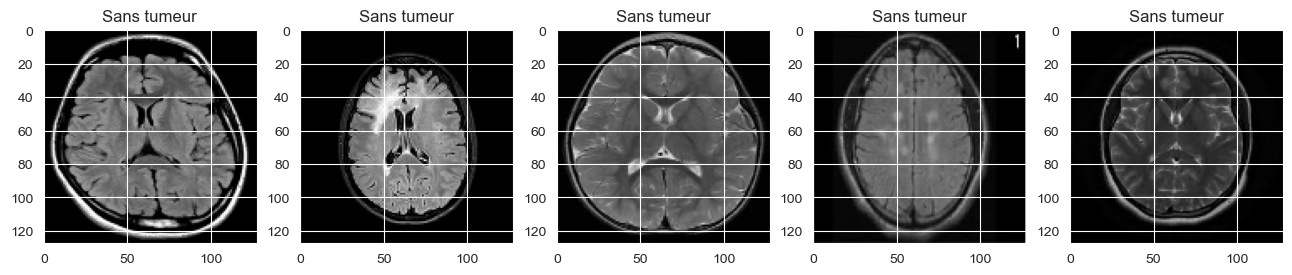

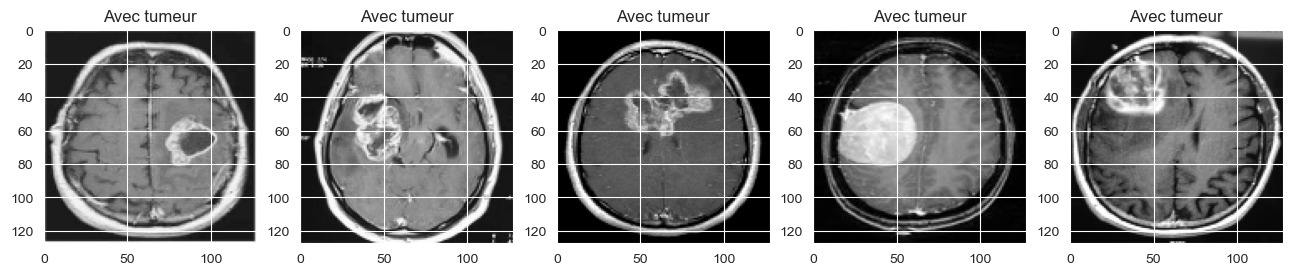

In [115]:
num_sample=5
no_tumor_imgs = no_tumor[np.random.choice(no_tumor.shape[0], num_sample, replace=False)]
with_tumor_imgs = with_tumor[np.random.choice(with_tumor.shape[0], num_sample, replace=False)]

plt.figure(figsize=(16,9))
for i in range(num_sample):
    plt.subplot(1, num_sample, i+1)
    plt.title('Sans tumeur')
    plt.imshow(no_tumor_imgs[i])

plt.figure(figsize=(16,9))
for i in range(num_sample):
    plt.subplot(1, num_sample, i+1)
    plt.title('Avec tumeur')
    plt.imshow(with_tumor_imgs[i])

 # Create Torch Dataset Class

## What is Pytorch's Abstract Dataset Class

In [116]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [118]:
class TumorDT(Dataset):
    def __init__(self):

        with_tumor = []
        no_tumor = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            with_tumor.append(img)

        for f in glob.iglob("./data/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            no_tumor.append(img)

        #images
        with_tumor = np.array(with_tumor,dtype=np.float32)
        no_tumor = np.array(no_tumor,dtype=np.float32)

        #labels
        with_tumor_label = np.ones(with_tumor.shape[0], dtype=np.float32)
        no_tumor_label = np.zeros(no_tumor.shape[0], dtype=np.float32)
        # Concatenates
        self.images = np.concatenate((with_tumor, no_tumor), axis=0)
        self.labels = np.concatenate((with_tumor_label, no_tumor_label))

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        item = {'image': self.images[index], 'label':self.labels[index]}
        return item

    def normalize(self):
        self.images = self.images/255.0

In [117]:
mri_dataset = TumorDT()
mri_dataset.normalize()